In [1]:
import nltk
import pickle
import torch
import pandas as pd

import matplotlib.pyplot as plt
from collections import Counter

from nltk.corpus import stopwords

position_words =['right', 'left', 'top', 'bottom', 'middle', 'mid', 'front', 'closest', 'nearest', 'center', 'central',
                               'corner', 'upper', 'back', 'far', 'leftmost', 'lower', 'low', 'rightmost',
                               'farthest', 'furthest', 'next', 'last', 'up', 'above', 'below', 'down', 'side']


color_words = ['white', 'green', 'blue', 'red', 'yellow', 'black', 'brown', 'pink', 'dark', 'darker', 'orange',
                            'gray', 'purple', 'beige', 'bright']

size_words = ["big", "bigger", "small", "smaller", "tall", "taller", "large", "larger", "little", "short", "shorter",
                           'tiny', "long", "longer", 'huge']

rel_pos_words=['above', 'about', 'below',"behind" 'beneath', 'beside', 'between', 'by','against', 
               'from', 'through', 'under', 'underneath', 'with','near', 'inside', 'from']

In [2]:
def load_data(model,mode, dataset, split):
#load predicted and gold bounding boxes

    try:

        #the predicted bounding box
        with open(r"/home/users/fschreiber/project/bboxes_"+model+"/"+dataset+"/"+split+"_pred_bbox_list.p","rb") as f:
            pred_bbox_list=list(pickle.load(f))

        if mode=="non_inc":
            #the target bounding box
            with open(r"/home/users/fschreiber/project/bboxes_noninc_"+model+"/"+dataset+"/"+split+"_pred_bbox_list.p","rb") as f:
                target_bbox_list=list(pickle.load(f))

        elif mode == "inc":
            #the target bounding box
            with open(r"/home/users/fschreiber/project/bboxes_"+model+"/"+dataset+"/"+split+"_target_bbox_list.p","rb") as f:
                target_bbox_list=list(pickle.load(f))
        else:
            print("The mode can only be non_inc or inc")
            return -1,-1,-1,-1,-1

        #the number of one sentence split up incrementally ("the left zebra" would have length 3)
        with open(r"/home/users/fschreiber/project/incremental_pickles/length_incremental_units/"+dataset+"_"+split+"_length_unit.p","rb") as f:
            inc_len=pickle.load(f)

        #the original model data split up incrementally
        data_model=torch.load("/home/users/fschreiber/project/ready_inc_data/"+dataset+"/"+dataset+"_"+split+".pth")

        with open(r"/home/users/fschreiber/project/binary_grouped/"+model+"/"+mode+"/"+dataset+split+".p","rb") as f:
            binary_grouped=pickle.load(f)

        
        if mode=="non_inc":
            target_bbox_list=[x for x,y in zip(target_bbox_list,inc_len) for _ in range(y)]
            
        if model=="TVG":
            pred_bbox_list,target_bbox_list=TVG_prep(pred_bbox_list,target_bbox_list)
                    

        return pred_bbox_list,target_bbox_list,inc_len,data_model,binary_grouped
    
    except FileNotFoundError as e:
        #print(e)
        
        return  -1,-1,-1,-1,-1
    


#TVG needs some extra adjustments to fit the same data format as Resc
def TVG_prep(pred_bbox_list,target_bbox_list):
    #print("TVG")
    for ind,(pred,targ) in enumerate (zip (pred_bbox_list,target_bbox_list)):

        pred=pred.view(1,-1)

        pred=xywh2xyxy(pred)
        pred=torch.clamp(pred,0,1)

        pred_bbox_list[ind]=pred

        targ=targ.view(1,-1)
        targ=xywh2xyxy(targ)

        target_bbox_list[ind]=targ
    return pred_bbox_list,target_bbox_list

#copied from TransVG needed to transform the bounding box vectors
def xywh2xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)


In [3]:
pred_bbox_list,target_bbox_list,inc_len,model,binary_grouped=load_data("ReSc","inc","unc+","testA")


In [4]:
#group sentences that belong to one incremental unit
def group_by_increment(bbox_list,inc_len):
    counter=0
    group_list=[]
    for i in inc_len:
        
        group_list.append(bbox_list[counter:counter+i])
        counter=counter+i
    return group_list

model_group=group_by_increment(model,inc_len)

In [5]:
#split up the list into entries where each guess is correct,wrong or mixed
def split_by_correct(binary_grouped):
    only_one=[]
    only_zero=[]
    only_mix=[]
    
    for index,entry in enumerate(binary_grouped):
        if all(p == 1 for p in entry):
            only_one.append(index)
        elif all (p ==0 for p in entry):
            only_zero.append(index)
        else:
            only_mix.append(index)
    
    return only_one,only_zero,only_mix

only_one,only_zero,only_mix=split_by_correct(binary_grouped)


In [6]:
def filter_by_category(model_group, word_list, only_one, only_zero, only_mix):
    
    one = []
    zero = []
    mixed = []

   
    for i in range(len(model_group)):
       
       #get sentence
        sent = model_group[i][-1][3]

        # Check if 'word_list' is equal to 'stopwords'
        if word_list == stopwords:
           
           #check for each word if it is a stopword
            for word in word_list.words():
                if word in sent.split():
                    # Depending on whether the examples is completly correct(only_one) 
                    # completly incorrect(only_zero) or mixed add to that list
                    if i in only_one:
                        one.append(word)
                    elif i in only_zero:
                        zero.append(word)
                    elif i in only_mix:
                        mixed.append(word)
                    else:
                       #every index should appear in one list if this does not happen 
                       #somethig broke in the index lists
                        print("Index", i, "does not appear in any list")
        else:
            # Loop through each word in 'word_list' and check if it appears in the sentence
            for word in word_list:
                if word in sent.split():
                    # Depending on whether 'i' is in 'only_one', 'only_zero', or 'only_mix', append the word to the respective list
                    if i in only_one:
                        one.append(word)
                    elif i in only_zero:
                        zero.append(word)
                    elif i in only_mix:
                        mixed.append(word)
                    else:
                        
                        print("Index", i, "does not appear in any list")

    # Return the three lists containing words that match the criteria
    return one, zero, mixed

# Call the 'filter_by_category' function with specific arguments and store the results in 'one', 'zero', and 'mixed' lists
one, zero, mixed = filter_by_category(model_group, position_words, only_one, only_zero, only_mix)


In [7]:
#calculates relative frequencies from absolute counts
def get_average_frequencies(counterlist):
    # Initialize an empty Counter to store the sum
    sum_counter = Counter()

    # Iterate through the list of counters and add them to the sum counter
    for counter in counterlist:
        sum_counter += counter

    # Calculate the average by dividing the count in each element of the sum counter by the number of counters
    num_counters = len(counterlist)
    average_counter = Counter({key: count / num_counters for key, count in sum_counter.items()})

    # Print the average Counter
    return average_counter

one_count=Counter(one)
zero_count=Counter(zero)

for item, count in one_count.items():
    one_count[item] /= len(only_one)

           
for item, count in zero_count.items():
    zero_count[item] /= len(only_zero)



In [8]:
#Plot a graph showing the frequency of correct and incorrect examples
def plot_correct_and_incorrect(one_count,zero_count,type):
    
    # get all words present 
    all_labels = set(one_count.keys()) | set(zero_count.keys())

    # get the frequency for the correct and incorrect condition
    one_value = [one_count[label] if label in one_count else 0 for label in all_labels]
    zero_value = [zero_count[label] if label in zero_count else 0 for label in all_labels]

    # Sort the combined data based on frequency of the correct condition in ascending order
    sorted_combined = sorted(zip(all_labels, one_value, zero_value), key=lambda x: x[1])

    # Extract labels and sorted values for both data sets
    print(type)
    if type=="Stop":
        labels, sorted_values1, sorted_values2 = zip(*sorted_combined[-20:])

    else:
        labels, sorted_values1, sorted_values2 = zip(*sorted_combined)


    # Create a figure and a set of subplots
    fig, ax = plt.subplots()

    # Set the positions and width for the bars
    positions = range(len(labels))
    width = 0.35

    # Create the bar plots for the combined and sorted Counter data
    ax.bar(positions, sorted_values1, width, label="Correct Examples")
    ax.bar([pos + width for pos in positions], sorted_values2, width, label="Incorrect Examples")

    # Set labels, title, and legend
    ax.set_xlabel(type+' Words')
    ax.set_ylabel('Frequency')
    ax.set_title("Frequency of "+type+" words in correct and incorrect examples")
    ax.set_xticks([pos + width/2 for pos in positions])
    ax.set_xticklabels(labels, rotation=90, ha='center')
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

#plot_correct_and_incorrect(one_counter,zero_counter,"Stop")

unctestB
unctestA
uncval
unc+testB
unc+testA
unc+val
gref_umdval
gref_umdtest
grefval
Stop


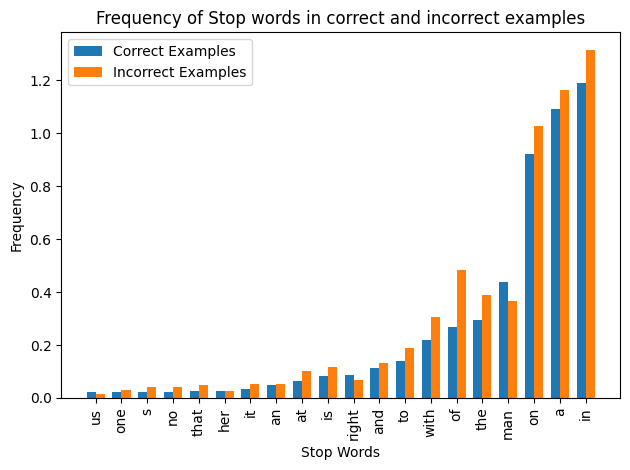

In [9]:
word_list=stopwords
type="Stop"
#setting="all"
mode="inc"
model_input="ReSc"
split_list=["testB","testA","val","test"]
dataset_list=["unc","unc+","gref_umd","gref"]
#dataset_list=["gref_umd"]
#split_list=["test"]

one_all=[]
zero_all=[]
mixed_all=[]

pos_all,color_all,size_all,rel_pos_all,stop_all,rest_all=([] for i in range(6))

#load the data
for file in dataset_list:
    for split in split_list:
    
        #if the data set does not exist ignore
        pred_bbox_list,target_bbox_list,inc_len,model,binary_grouped= load_data(model_input,mode,file,split)
        if pred_bbox_list==-1 or target_bbox_list==-1:
             
             pass
        
        else:
        
            print(file+split)

            model_group=group_by_increment(model,inc_len)

            only_one,only_zero,only_mix=split_by_correct(binary_grouped)
            one,zero,mix=filter_by_category(model_group,word_list,only_one,only_zero,only_mix)

            one_count=Counter(one)
            zero_count=Counter(zero)
            mix_count=Counter(mix)

            for item, count in one_count.items():
                one_count[item] /= len(only_one)

            for item, count in mix_count.items():
                mix_count[item] /= len(mix)

            for item, count in zero_count.items():
                zero_count[item] /= len(only_zero)

            
            one_all.append(one_count)
            zero_all.append(zero_count)
            mixed_all.append(mix_count)

one_counter=get_average_frequencies(one_all)
zero_counter=get_average_frequencies(zero_all)

plot_correct_and_incorrect(one_counter,zero_counter,type)


            

In [10]:
#Plot the freqeuncy of one condition
def frequency_plot(count):
    # Sort the Counter items based on frequency in ascending order
    sorted_data1 = sorted(count.items(), key=lambda x: x[1])
    
    # Extract labels and values from the sorted Counter items
    labels, values = zip(*sorted_data1)

    # Create figure 
    fig, ax = plt.subplots()
    positions = range(len(labels))
    width = 0.4
    ax.bar(positions, values, width)

    # Set labels and title
    ax.set_xlabel('Colors')
    ax.set_ylabel('Frequency')
    ax.set_title('Frequency of Colors in Counter (Ascending Order)')

    # Set x-axis labels and adjust layout
    ax.set_xticks([pos for pos in positions])
    ax.set_xticklabels(labels, rotation=45, ha='right')

    # Show the plot
    plt.tight_layout()
    plt.show()
